In [1]:
#import
import boto3
import os
from datetime import datetime, timezone
import shutil
import configparser

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
import numpy as np

import cv2
import numpy as np
import io
import matplotlib.pyplot as plt
from PIL import Image

2024-03-26 17:06:49.026375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the .cfg file
config.read('/mnt/stor/ceph/csb/marsfarm/projects/aws_key/aws_key.cfg')

# Accessing the values
# Access a specific section
settings = config['Secrets']

#DO NOT PRINT secret access key or key id
session = boto3.Session(
    aws_access_key_id=settings['aws_access_key_id'],
    aws_secret_access_key=settings['aws_secret_access_key'],
)

s3 = session.client('s3')

In [3]:
# Call S3 to list current buckets
response = s3.list_buckets()

# Get a list of all bucket names from the response and print them
bucket_names = [bucket['Name'] for bucket in response['Buckets']]

print(bucket_names)

# Pagination configuration
paginator = s3.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket='mv1-production')

['aged-raw-imports', 'dev-jackie-bucket', 'gif-bucket-drew', 'henry-metadata-testing', 'iot-test-buckets', 'micds', 'ml-v043-micds-01', 'ml-v043-micds-02', 'ml-v043-micds-03', 'ml-v043-micds-04', 'ml-v043-micds-05', 'ml-v043-testing-01', 'mm-v021-asa-1', 'mm-v021-asa-1-backup', 'mm-v021-asa-2', 'mm-v021-asa-3', 'mm-v021-asa-4', 'mm-v021-asa-5', 'mm-v021-asa-6', 'mm-v021-asa-7', 'mm-v021-bgc-1', 'mm-v021-bgc-1-backup', 'mm-v021-globalimpactacademy-1', 'mm-v021-marsfarmtesting-1', 'mm-v021-nburlingtonmiddleschool-1', 'mm-v021-scc-1', 'mm-v021-scc-1-backup', 'mm-v021-scc-2', 'mm-v021-scc-3', 'mm-v021-stjoeshighschool-1', 'mm-v021-stjoeshighschool-2', 'mm-v021-stjoeshighschool-backup', 'mm-v023-asa-01', 'mm-v023-asa-02', 'mm-v023-asa-03', 'mm-v023-asa-04', 'mm-v023-asa-05', 'mm-v023-asa-06', 'mm-v023-asa-07', 'mm-v023-asa-08', 'mm-v023-asa-09', 'mm-v023-asa-10', 'mm-v023-asa-11', 'mm-v023-asa-12', 'mm-v023-asa-13', 'mm-v023-asa-14', 'mm-v023-asa-15', 'mm-v023-asa-16', 'mm-v023-asa-17', 'mm

In [4]:
# Load the pre-trained MobileNetV2 model
model = MobileNetV2(weights='imagenet')

def is_plant(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    # Make predictions
    predictions = model.predict(img_preprocessed)

    # Decode and analyze predictions
    decoded_predictions = decode_predictions(predictions, top=5)[0]
    print(decoded_predictions)
    for _, label, probability in decoded_predictions:
        if label in ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']:  # Example plant categories
            print(f"Detected a plant ({label}) with probability {probability:.2f}")
            return True
    return False


712
{}


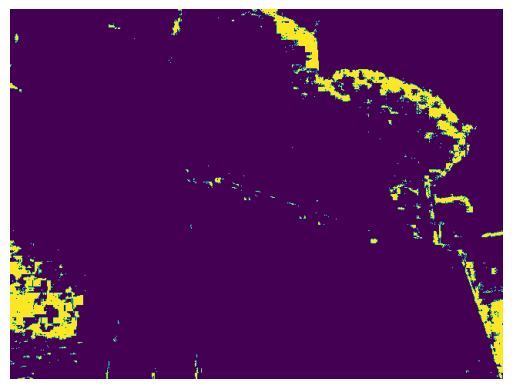

15767
1000
{'trial_id': '6401372e70b2230014a2b82d', 'currtime': '2023-04-25_1510', 'day_number': '54', 'device_id': '63027bdca326c97b3a44cb44'}


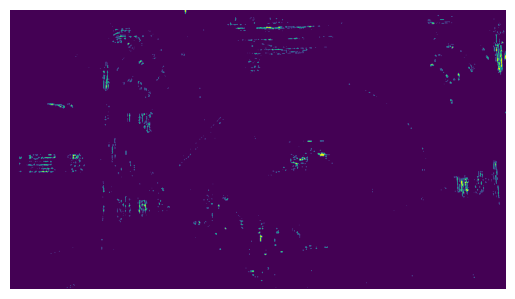

12939


In [8]:
#test out opening an image using opencv and checking if it has a plant in it
def check_if_has_plant_s3(bucket_name):
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name)
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg']

    for page in page_iterator:
        print(len(page.get('Contents', [])))
        for obj in page.get('Contents', []):
            if any(obj['Key'].lower().endswith(ext) for ext in image_extensions):
                response = s3.get_object(Bucket=bucket_name, Key=obj['Key'])
                image_data = response['Body'].read()
                print(response['Metadata'])
                
                # Load the image data into a PIL Image object
                image = Image.open(io.BytesIO(image_data))
            
                # Convert the PIL Image to a NumPy array
                image_np = np.array(image)
            
                # Plot the image
                # Convert the image from RGB to HSV
                hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
                
                # Define the range of green color in HSV
                # Adjusted range of green color in HSV to reduce false positives
                lower_green = np.array([25, 40, 40])
                upper_green = np.array([90, 255, 255])
                
                # Threshold the HSV image to get only green colors
                mask = cv2.inRange(hsv, lower_green, upper_green)
                # Plot the image
                plt.imshow(mask)
                plt.axis('off')  # Hide axis
                plt.show()
                count_non_black = cv2.countNonZero(mask)
                print(count_non_black)
                
                # Display the image            
                return
    print("No images found in the bucket.")

check_if_has_plant_s3('mvp-v1-asa-06')
check_if_has_plant_s3('mv1-production')
#check_if_has_plant_s3('mvp-v1-asa-05')
#mvp-v1-asa-05

In [16]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
def count_images_in_bucket(bucket_name):
    # Supported image extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg']
    
    # Initialize a counter
    image_count = 0
    
    # Paginator to handle buckets with many objects
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name)
    
    # Iterate through each object in the bucket
    def is_image(obj_key):
        image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg']
        return any(obj_key.lower().endswith(ext) for ext in image_extensions)

    keys = []
    #page_count = 0
    for page in page_iterator:
        #add a temporary parameter to the page dictionary, and delete after testing
        page["ResponseMetadata"]["TestDirectoryParameter"] = 1
        print(page["ResponseMetadata"])
        del page["ResponseMetadata"]["TestDirectoryParameter"]
        if 'Contents' in page:
            keys.extend([obj['Key'] for obj in page['Contents']])

    with ThreadPoolExecutor() as executor:
        image_count = executor.map(is_image, keys)
    return sum(image_count)

count_images_in_bucket('mvp-v1-asa-06')

{'RequestId': '64NQDDCPX2RQHC6T', 'HostId': 'p04kKAYCQ4A2fUVTvpOcarRRscmEa0EdbWaFIxCgJJCeQjlILrQPX/gI9Vs0E4w8gfCThCECf6bj96jBb0Rh0Q==', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'p04kKAYCQ4A2fUVTvpOcarRRscmEa0EdbWaFIxCgJJCeQjlILrQPX/gI9Vs0E4w8gfCThCECf6bj96jBb0Rh0Q==', 'x-amz-request-id': '64NQDDCPX2RQHC6T', 'date': 'Tue, 26 Mar 2024 22:13:31 GMT', 'x-amz-bucket-region': 'us-east-2', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0, 'TestDirectoryParameter': 1}


712